# Deutsch Algorithm

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
qml.drawer.use_style(style='sketch')

**Balanced or constant?**

Consider single variable function $f(x)$ defined as follows:
$$
f: \{0, 1\} \rightarrow \{0, 1\}
$$

There are four possible functions:

1. $f_0(0) = 0, f_0(1) = 0$ - constant function
   
2. $f_1(0) = 0, f_1(1) = 1$ - balanced function
   
3. $f_2(0) = 1, f_2(1) = 0$ - balanced function
   
4. $f_3(0) = 1, f_3(1) = 1$ - constant function

We want to determine whether the function is constant or balanced.
How many times do we need to evaluate the function to determine this?

## Classical solution

In [3]:
def is_constant(f):
    return f(0) == f(1) # need two evaluations to check if constant

## Quantum solution

### Quantum Oracle

For quantum computing, we need to define a quantum oracle for the function.

First, let's define an operator $\mathcal{O}_f$ such that:
$$
\mathcal{O}_f |x\rangle = |f(x)\rangle
$$

But this equation violates the unitarity of the operator for constant functions.
(For constant functions, the operator is not reversible.)

To fix this, we can add an extra qubit $|y\rangle$ and define the operator as follows:

$$
U_f (|x\rangle \otimes |y\rangle) = |x\rangle \otimes |y \oplus f(x)\rangle
$$

where $\oplus$ is the bitwise XOR operation.

For all possible states of $|x\rangle$ and $|y\rangle$, the output of the operator is:

- $|0\rangle \otimes |0\rangle \rightarrow |0\rangle \otimes |f(0)\rangle$
- $|0\rangle \otimes |1\rangle \rightarrow |0\rangle \otimes |f(0) \oplus 1\rangle$
- $|1\rangle \otimes |0\rangle \rightarrow |1\rangle \otimes |f(1)\rangle$
- $|1\rangle \otimes |1\rangle \rightarrow |1\rangle \otimes |f(1) \oplus 1\rangle$

These represent the operator $U_f$ is orthogonal.
And the operator is also reversible.

$$
U_f(U_f(|x\rangle \otimes |y\rangle)) = U_f(|x\rangle \otimes |y \oplus f(x)\rangle) = |x\rangle \otimes |y \oplus f(x) \oplus f(x)\rangle = |x\rangle \otimes |y\rangle
$$

Therefore the operator is unitary.

And with computational basis, the operator can be represented as follows:

- `[1,0,0,0] -> [1,0,0,0] if f(0) = 0 else [0,1,0,0]`
- `[0,1,0,0] -> [0,1,0,0] if f(0) = 0 else [1,0,0,0]`
- `[0,0,1,0] -> [0,0,1,0] if f(1) = 0 else [0,0,0,1]`
- `[0,0,0,1] -> [0,0,0,1] if f(1) = 0 else [0,0,1,0]`

$$
U_f = \begin{bmatrix}
1-f(0) & f(0) & 0 & 0 \\
f(0) & 1-f(0) & 0 & 0 \\
0 & 0 & 1-f(1) & f(1) \\
0 & 0 & f(1) & 1-f(1)
\end{bmatrix}
$$


In [4]:
def f(x):
    return 1

In [5]:
def U(f):
    return np.array([
        [1 - f(0), f(0), 0, 0],
        [f(0), 1 - f(0), 0, 0],
        [0, 0, 1 - f(1), f(1)],
        [0, 0, f(1), 1 - f(1)]
    ])

In [6]:
dev = qml.device('default.qubit', wires=2)

In [7]:
@qml.qnode(dev)
def oracle_test(f, x):
    qml.QubitStateVector(x, wires=[0, 1])
    qml.QubitUnitary(U(f), wires=[0, 1])
    return qml.state()

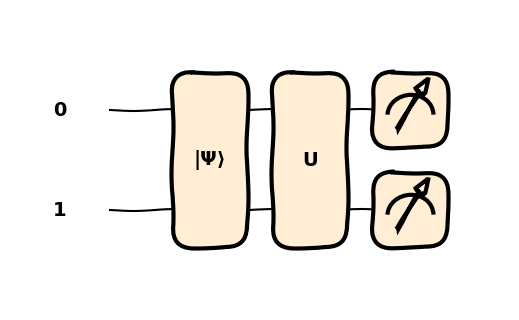

tensor([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j], requires_grad=True)

In [8]:
qml.draw_mpl(oracle_test)(f, [1,0,0,0])
plt.show()
oracle_test(f, [1,0,0,0])

Then now, the question is how many times do we need to apply the operator to determine whether the function is constant or balanced?

- Input binary qubits only then oracle's output's are binary qubits too. Thus, we need two evaluations.

- Then what if we input entangled qubits?

In [9]:
@qml.qnode(dev)
def deutsch(f):
    qml.PauliX(wires=1)
    qml.Barrier(wires=[0,1])
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.QubitUnitary(U(f), wires=[0, 1])
    qml.Hadamard(wires=0)
    return qml.probs(wires=0)

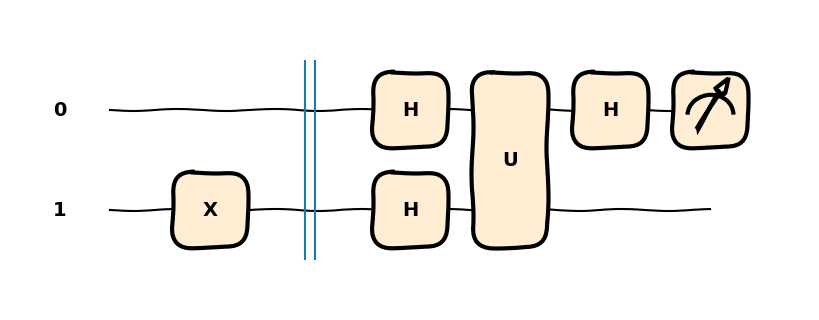

In [10]:
qml.draw_mpl(deutsch)(f)
plt.show()

**Explanation of the circuit**

1) Apply X gate to the second qubit to make it $|1\rangle$.

2) Apply Hadamard gate to both qubits to make them entangled.
    $$
    \begin{aligned}
    (H \otimes H) (|0\rangle \otimes |1\rangle) &= \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) \\
    &= \frac{1}{2}(|00\rangle - |01\rangle + |10\rangle - |11\rangle)
    \end{aligned}
    $$

3) Apply the oracle operator to the qubits.
    $$
    \begin{aligned}
    \frac{1}{2}(|00\rangle - |01\rangle + |10\rangle - |11\rangle) &\rightarrow \frac{1}{2}(|0\rangle \otimes |f(0)\rangle - |0\rangle \otimes |f(0) \oplus 1\rangle + |1\rangle \otimes |f(1)\rangle - |1\rangle \otimes |f(1) \oplus 1\rangle) \\
    &= \frac{1}{2}(|0\rangle \otimes (|f(0)\rangle - |f(0) \oplus 1\rangle) + |1\rangle \otimes (|f(1)\rangle - |f(1) \oplus 1\rangle))
    \end{aligned}
    $$
    We can use the trick:
    $$
    |f(0)\rangle - |f(0) \oplus 1\rangle = (-1)^{f(0)}(|0\rangle - |1\rangle) \\
    |f(1)\rangle - |f(1) \oplus 1\rangle = (-1)^{f(1)}(|0\rangle - |1\rangle)
    $$
    Then, the state becomes:
    $$
    \begin{aligned}
    &\frac{1}{2}(|0\rangle \otimes (-1)^{f(0)}(|0\rangle - |1\rangle) + |1\rangle \otimes (-1)^{f(1)}(|0\rangle - |1\rangle)) \\
    =& \frac{1}{2}((-1)^{f(0)}|0\rangle \otimes (|0\rangle - |1\rangle) + (-1)^{f(1)}|1\rangle \otimes (|0\rangle - |1\rangle)) \\
    =& \frac{1}{2}((-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle) \otimes (|0\rangle - |1\rangle) \\
    =& \frac{1}{\sqrt{2}}((-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)
    \end{aligned}
    $$
    This means two qubits are decoupled.

4) Apply Hadamard gate to the first qubit.
    $$
    \begin{aligned}
    \frac{1}{\sqrt{2}}((-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle) &\rightarrow \frac{1}{2}((-1)^{f(0)}(|0\rangle + |1\rangle) + (-1)^{f(1)}(|0\rangle - |1\rangle)) \\
    &= \frac{1}{2}((-1)^{f(0)} + (-1)^{f(1)})|0\rangle + \frac{1}{2}((-1)^{f(0)} - (-1)^{f(1)})|1\rangle
    \end{aligned}
    $$
    - If $f$ is constant, then the state lies on the $|0\rangle$ axis.
    - If $f$ is balanced, then the state lies on the $|1\rangle$ axis.


In [11]:
f_vec = [
    lambda x: 0,
    lambda x: 1,
    lambda x: x,
    lambda x: 1 - x    
]

for f in f_vec:
    print(f'f(0) = {f(0)}, f(1) = {f(1)}, constant = {is_constant(f)}')
    prob = deutsch(f)
    if prob[0] > 0:
        print('constant')
    else:
        print('balanced')
    print()

f(0) = 0, f(1) = 0, constant = True
constant

f(0) = 1, f(1) = 1, constant = True
constant

f(0) = 0, f(1) = 1, constant = False
balanced

f(0) = 1, f(1) = 0, constant = False
balanced

